In [3]:
# load libraries
from datasets import load_dataset
import torch
from torchvision.ops import box_convert
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import pil_to_tensor, to_pil_image
from transformers import pipeline

import albumentations
import numpy as np


In [4]:
# load dataset
ds = load_dataset("Kili/plastic_in_river")
ds

  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'litter'],
        num_rows: 3407
    })
    test: Dataset({
        features: ['image', 'litter'],
        num_rows: 427
    })
    validation: Dataset({
        features: ['image', 'litter'],
        num_rows: 425
    })
})

In [5]:
train = ds['train']
val = ds['validation']
test = ds['test']


In [6]:
# set example
example = train[2]
example

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1280x720 at 0x7F1F1AB3A670>,
 'litter': {'label': [1, 1],
  'bbox': [[0.9218628406524658,
    0.7016893029212952,
    0.04143203794956207,
    0.036828476935625076],
   [0.15433433651924133,
    0.8453204035758972,
    0.06836286187171936,
    0.04419417306780815]]}}

In [7]:
print('image size: ' + str(example['image'].size))

image size: (1280, 720)


In [8]:
width = example['image'].size[0]
height = example['image'].size[1]

In [9]:
# all possible object categories
categories = train.features['litter'].feature['label']
categories

ClassLabel(names=['PLASTIC_BAG', 'PLASTIC_BOTTLE', 'OTHER_PLASTIC_WASTE', 'NOT_PLASTIC_WASTE'], id=None)

In [10]:
# resize bbox to image size
def resize_bbox(bbox, w, h):
    for x in range(len(bbox)):
        bbox[x][0] = bbox[x][0] * w
        bbox[x][1] = bbox[x][1] * h
        bbox[x][2] = bbox[x][2] * w
        bbox[x][3] = bbox[x][3] * h
    return bbox

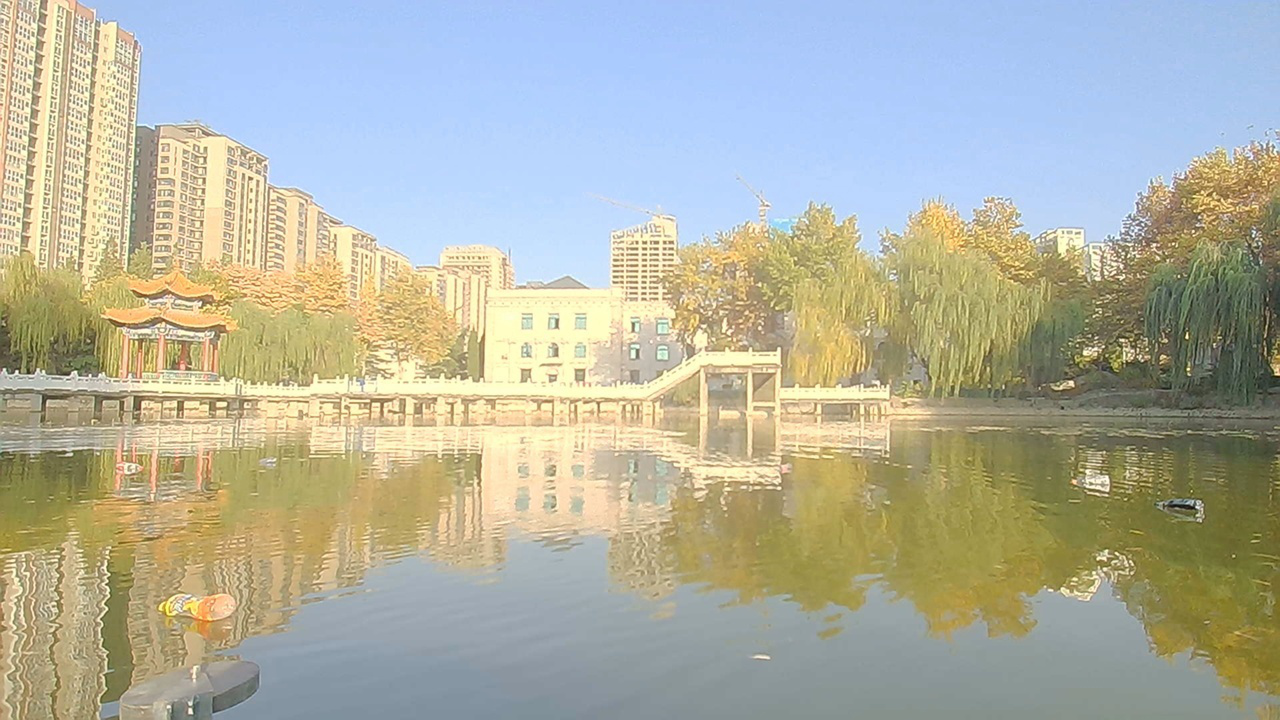

In [11]:
# show image without bbox
example['image']

In [12]:
# function to draw image with bounding boxes
def plot_image(example):
    bbox = resize_bbox(example['litter']['bbox'], width, height)
    boxes_xywh = torch.tensor(bbox)
    boxes_xyxy = box_convert(boxes_xywh, 'cxcywh', 'xyxy')
    
    labels = [categories.int2str(x) for x in example['litter']['label']]
    return to_pil_image(
        draw_bounding_boxes(
            pil_to_tensor(example['image']),
            boxes_xyxy,
            colors="red",
            labels=labels,
        )
    )

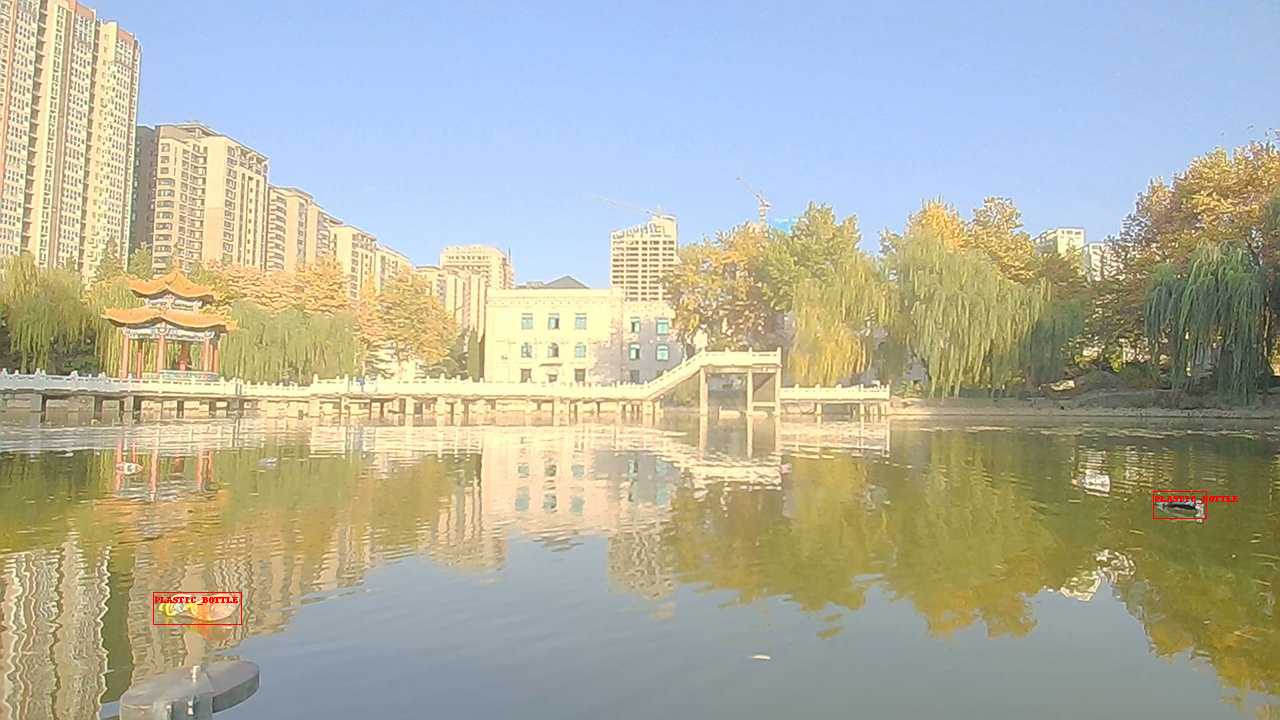

In [13]:
plot_image(example)

In [14]:
from transformers import AutoImageProcessor

checkpoint = "facebook/detr-resnet-50"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


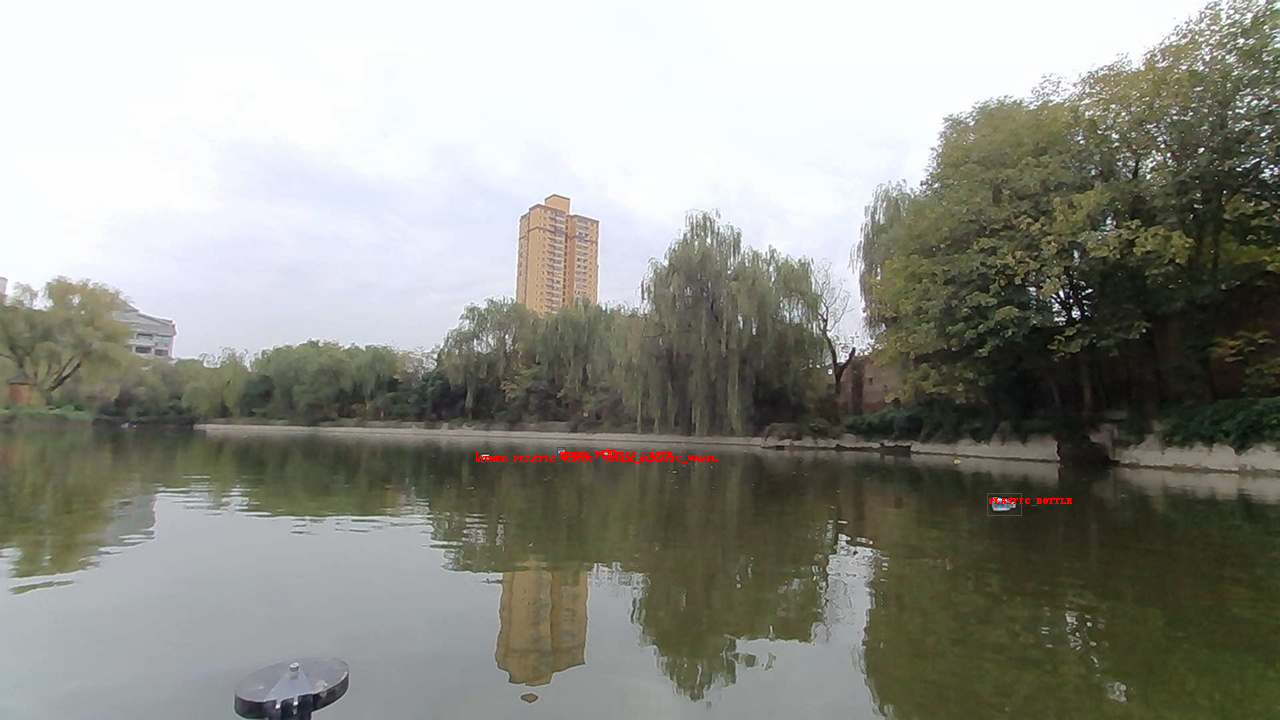

In [161]:
example = ds['train'][1]
plot_image(example)

In [16]:
example

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1280x720 at 0x7F1F198A8F70>,
 'litter': {'label': [1],
  'bbox': [[0.480611652135849,
    0.7237864136695862,
    0.055242717266082764,
    0.04419417306780815]]}}

In [162]:
transform1 = albumentations.Compose(
    [
        albumentations.Resize(480, 480),
        albumentations.HorizontalFlip(p=0.0),
        albumentations.RandomBrightnessContrast(p=1.0),
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=["category"]), #oder yolo, wenn ich später resize mache und nicht davor
)

# RGB PIL Image -> BGR Numpy array
image = np.flip(np.array(example['image']), -1)
out = transform1(
    image=image,
    bboxes=example['litter']['bbox'],
    category=example['litter']['label'],
)

In [120]:
out['bboxes'] = [i * 5 for i in out['bboxes']]

In [126]:
out['bboxes']

[(0.7850685715675354,
  0.7004762887954712,
  0.026415929198265076,
  0.030925966799259186),
 (0.3775545060634613,
  0.6334699988365173,
  0.01030865591019392,
  0.01374487392604351),
 (0.4387621581554413,
  0.6265975832939148,
  0.006442909594625235,
  0.011454061605036259),
 (0.47516459226608276,
  0.6300337910652161,
  0.009664364159107208,
  0.009163249284029007)]

In [115]:
example['litter']['bbox']

[[0.7850685715675354,
  0.7004762887954712,
  0.026415929198265076,
  0.030925966799259186],
 [0.3775545060634613,
  0.6334699988365173,
  0.01030865591019392,
  0.01374487392604351],
 [0.4387621581554413,
  0.6265975832939148,
  0.006442909594625235,
  0.011454061605036259],
 [0.47516459226608276,
  0.6300337910652161,
  0.009664364159107208,
  0.009163249284029007]]

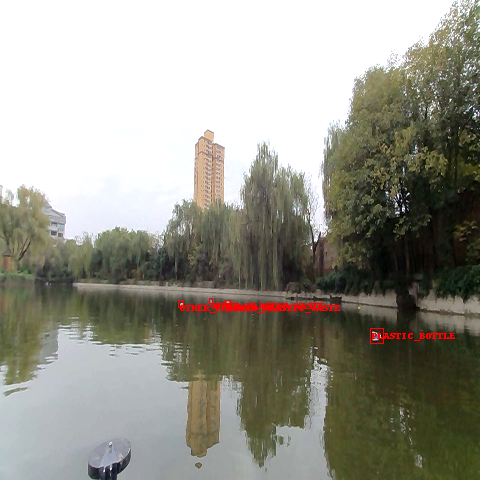

In [163]:
image = torch.tensor(out['image']).flip(-1).permute(2, 0, 1)
boxes_xywh = torch.stack([torch.tensor(x) for x in out['bboxes']])
#boxes_xywh = torch.multiply(boxes_xywh, 480)
boxes_xyxy = box_convert(boxes_xywh, 'cxcywh', 'xyxy')
labels = [categories.int2str(x) for x in out['category']]
to_pil_image(
    draw_bounding_boxes(
        image,
        boxes_xyxy,
        colors='red',
        labels=labels
    )
)

In [216]:
img_size = 480
transform = albumentations.Compose(
    [
        albumentations.Resize(img_size, img_size),
        albumentations.HorizontalFlip(p=0.0),
        albumentations.RandomBrightnessContrast(p=1.0),
    ],
    bbox_params=albumentations.BboxParams(format="yolo", label_fields=["category"]), #oder yolo, wenn ich später resize mache und nicht davor
)

In [217]:
def transforms(examples):
    images, bboxes, categories = [], [], []
    for image, objects in zip(examples['image'], examples['litter']):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(
            image=image,
            bboxes=objects['bbox'],
            category=objects['label']
        )
        images.append(torch.tensor(out['image']).flip(-1).permute(2, 0, 1))
        bboxes.append(torch.multiply(torch.tensor(out['bboxes']), img_size))
        categories.append(out['category'])
    return {'image': images, 'bbox': bboxes, 'category': categories}

In [218]:
ds['train'].set_transform(transforms)

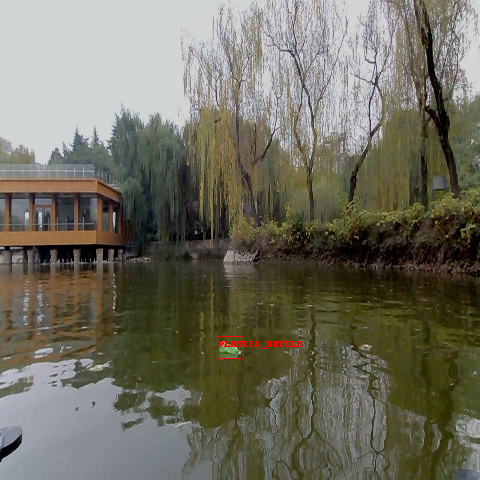

In [219]:
example = ds['train'][10]
to_pil_image(
    draw_bounding_boxes(
        example['image'],
        box_convert(example['bbox'], 'cxcywh', 'xyxy'),
        colors='red',
        labels=[categories.int2str(x) for x in example['category']]
    )
)

In [80]:

ds2 = load_dataset("cppe-5")
example2 = ds2['train'][0]
example2

  0%|          | 0/2 [00:00<?, ?it/s]

{'image_id': 15,
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=943x663 at 0x7F1DD94505B0>,
 'width': 943,
 'height': 663,
 'objects': {'id': [114, 115, 116, 117],
  'area': [3796, 1596, 152768, 81002],
  'bbox': [[302.0, 109.0, 73.0, 52.0],
   [810.0, 100.0, 57.0, 28.0],
   [160.0, 31.0, 248.0, 616.0],
   [741.0, 68.0, 202.0, 401.0]],
  'category': [4, 4, 0, 0]}}

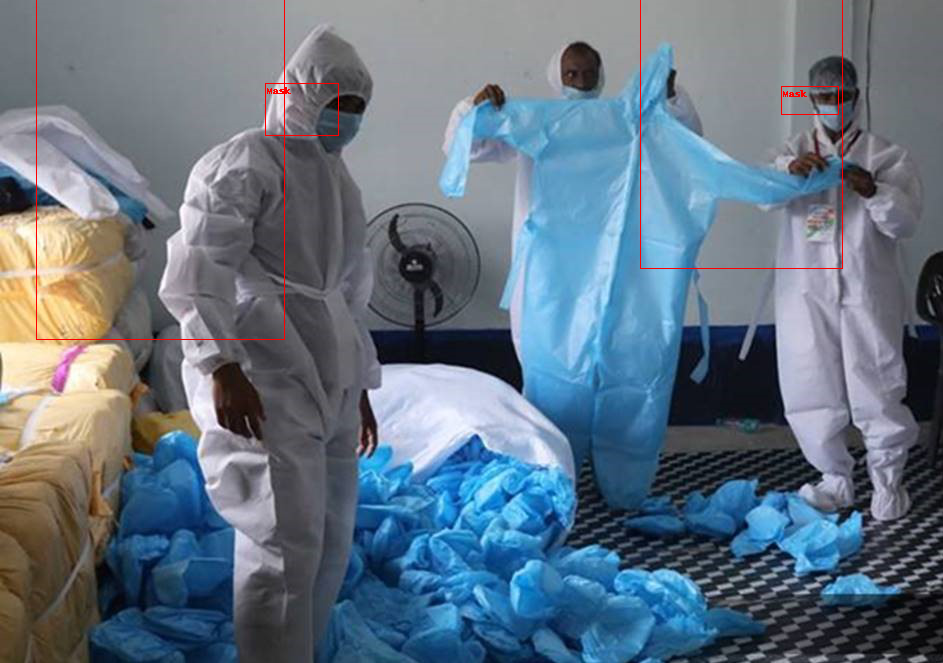

In [156]:
categories2 = ds2['train'].features['objects'].feature['category']

boxes_xywh2 = torch.tensor(example2['objects']['bbox'])
boxes_xyxy2 = box_convert(boxes_xywh2, 'xywh', 'xyxy')
labels2 = [categories2.int2str(x) for x in example2['objects']['category']]
to_pil_image(
    draw_bounding_boxes(
        pil_to_tensor(example2['image']),
        boxes_xyxy2,
        colors="red",
        labels=labels2,
    )
)

In [88]:
example2

{'image_id': 15,
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=943x663 at 0x7F1DD94505B0>,
 'width': 943,
 'height': 663,
 'objects': {'id': [114, 115, 116, 117],
  'area': [3796, 1596, 152768, 81002],
  'bbox': [[302.0, 109.0, 73.0, 52.0],
   [810.0, 100.0, 57.0, 28.0],
   [160.0, 31.0, 248.0, 616.0],
   [741.0, 68.0, 202.0, 401.0]],
  'category': [4, 4, 0, 0]}}

In [91]:
transform2 = albumentations.Compose([
    albumentations.Resize(943, 663),
    albumentations.HorizontalFlip(p=1.0),
    albumentations.RandomBrightnessContrast(p=1.0),
], bbox_params=albumentations.BboxParams(format='coco',  label_fields=['category']))

# RGB PIL Image -> BGR Numpy array
image2 = np.flip(np.array(example2['image']), -1)
out2 = transform2(
    image=image2,
    bboxes=example2['objects']['bbox'],
    category=example2['objects']['category'],
)

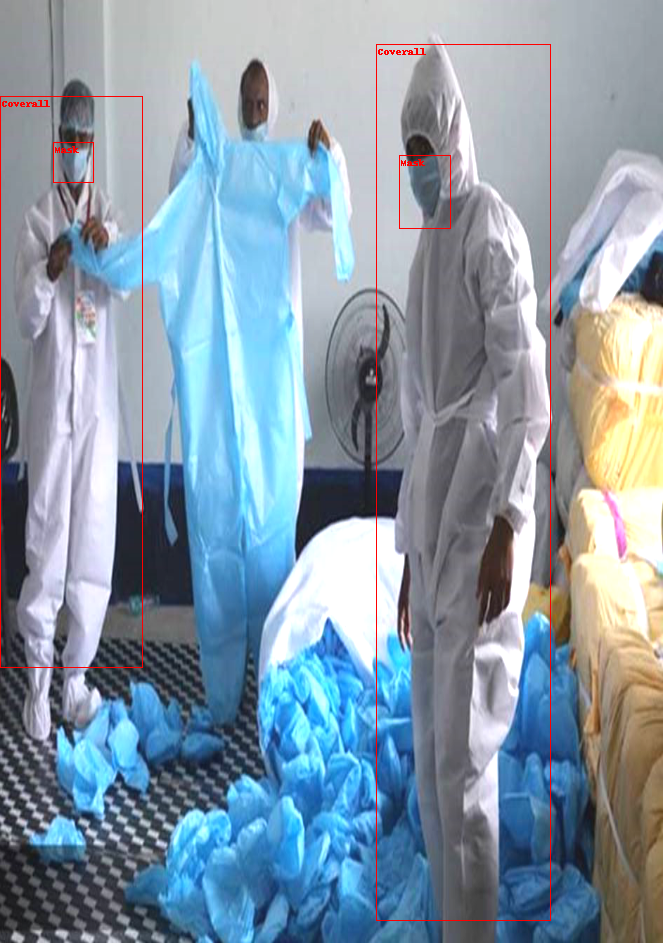

In [92]:
image2 = torch.tensor(out2['image']).flip(-1).permute(2, 0, 1)
boxes_xywh2 = torch.stack([torch.tensor(x) for x in out2['bboxes']])
boxes_xyxy2 = box_convert(boxes_xywh2, 'xywh', 'xyxy')
labels2 = [categories2.int2str(x) for x in out2['category']]
to_pil_image(
    draw_bounding_boxes(
        image2,
        boxes_xyxy2,
        colors='red',
        labels=labels2
    )
)